# COMP4211 Project: Exploring Stock Price Prediction with Past Data and Market Sentiment


## Import libraries

In [ ]:
import pandas as pd
from IPython.display import display
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
# For time stamps
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from keras.utils import plot_model
import tensorflow as tf
import unicodedata
from matplotlib.dates import DateFormatter
from pickle import dump
from pickle import load
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
# Initial library setup
nltk.download('vader_lexicon')
%matplotlib inline
yf.pdr_override()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Connect to Google Drive

In [ ]:
# Unzip tweets dataset
from google.colab import drive
import os
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/COMP4211/project/stock_tweets.csv.zip"
!unzip "$data_path" > /dev/null 2>&1

Mounted at /content/drive


## Dataset Preparation

### Prepare the stock data from yFinance

In [ ]:
# Prepare the historical stock prices we'll use for this analysis
company = ['TSLA', 'TSM', 'AAPL']

end = datetime(2022, 9, 30)
start = datetime(end.year - 1, end.month, end.day-1) #get the data starting from 1 year before today

for stock in company:
    globals()[stock] = yf.download(stock, start, end)

company_list = [TSLA, TSM, AAPL]
company_name = ['TSLA', 'TSM', 'AAPL']

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

stock_df = pd.concat(company_list, axis=0)
stock_df = stock_df.reset_index()
stock_df['Date'] = stock_df['Date'].dt.strftime('%Y-%m-%d')
stock_df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,company_name
749,2022-09-16,151.210007,151.350006,148.369995,150.699997,149.423477,162278800,AAPL
750,2022-09-19,149.309998,154.559998,149.100006,154.479996,153.171463,81474200,AAPL
751,2022-09-20,153.399994,158.080002,153.080002,156.899994,155.570984,107689800,AAPL
752,2022-09-21,157.339996,158.740005,153.600006,153.720001,152.417923,101696800,AAPL
753,2022-09-22,152.380005,154.470001,150.910004,152.740005,151.446198,86652500,AAPL
754,2022-09-23,151.190002,151.470001,148.559998,150.429993,149.155777,96029900,AAPL
755,2022-09-26,149.660004,153.770004,149.639999,150.770004,149.492905,93339400,AAPL
756,2022-09-27,152.740005,154.720001,149.949997,151.759995,150.474518,84442700,AAPL
757,2022-09-28,147.639999,150.639999,144.839996,149.839996,148.570770,146691400,AAPL
758,2022-09-29,146.100006,146.720001,140.679993,142.479996,141.273087,128138200,AAPL


In [ ]:
display(TSLA.describe())
display(TSM.describe())
display(AAPL.describe())

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,300.136008,307.486021,292.114058,299.709104,299.709104,8.051190e+07
std,46.139272,46.789896,44.685331,45.788283,45.788283,2.546499e+07
min,207.949997,217.973328,206.856674,209.386673,209.386673,3.504270e+07
25%,266.513336,273.166656,260.723328,266.923340,266.923340,6.255570e+07
50%,298.500000,303.709991,289.130005,296.666656,296.666656,7.695630e+07
75%,335.600006,344.950012,327.510010,336.336670,336.336670,9.347310e+07
max,411.470001,414.496674,405.666656,409.970001,409.970001,1.885563e+08


,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,102.571146,103.826957,101.205020,102.468972,98.256004,1.098684e+07
std,16.610708,16.884256,16.291954,16.530142,15.387862,5.240549e+06
min,70.519997,70.680000,68.480003,69.279999,67.302773,3.888200e+06
25%,87.129997,88.419998,86.400002,87.690002,84.592354,7.739000e+06
50%,104.000000,104.599998,101.300003,102.089996,97.631058,1.018910e+07
75%,118.169998,119.529999,116.389999,117.790001,112.310631,1.283510e+07
max,140.750000,145.000000,138.919998,140.660004,134.516479,5.202000e+07


,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,158.391146,160.470277,156.514506,158.579842,156.816470,8.907666e+07
std,12.452384,12.393873,12.348350,12.350303,12.179678,2.647904e+07
min,130.070007,132.389999,129.039993,130.059998,128.779449,4.100000e+07
25%,148.809998,150.130005,147.479996,148.960007,147.245819,7.020790e+07
50%,159.570007,161.800003,156.529999,159.220001,157.500153,8.444270e+07
75%,169.080002,171.050003,167.139999,168.880005,167.062790,1.005894e+08
max,182.630005,182.940002,179.119995,182.009995,179.724548,1.954327e+08


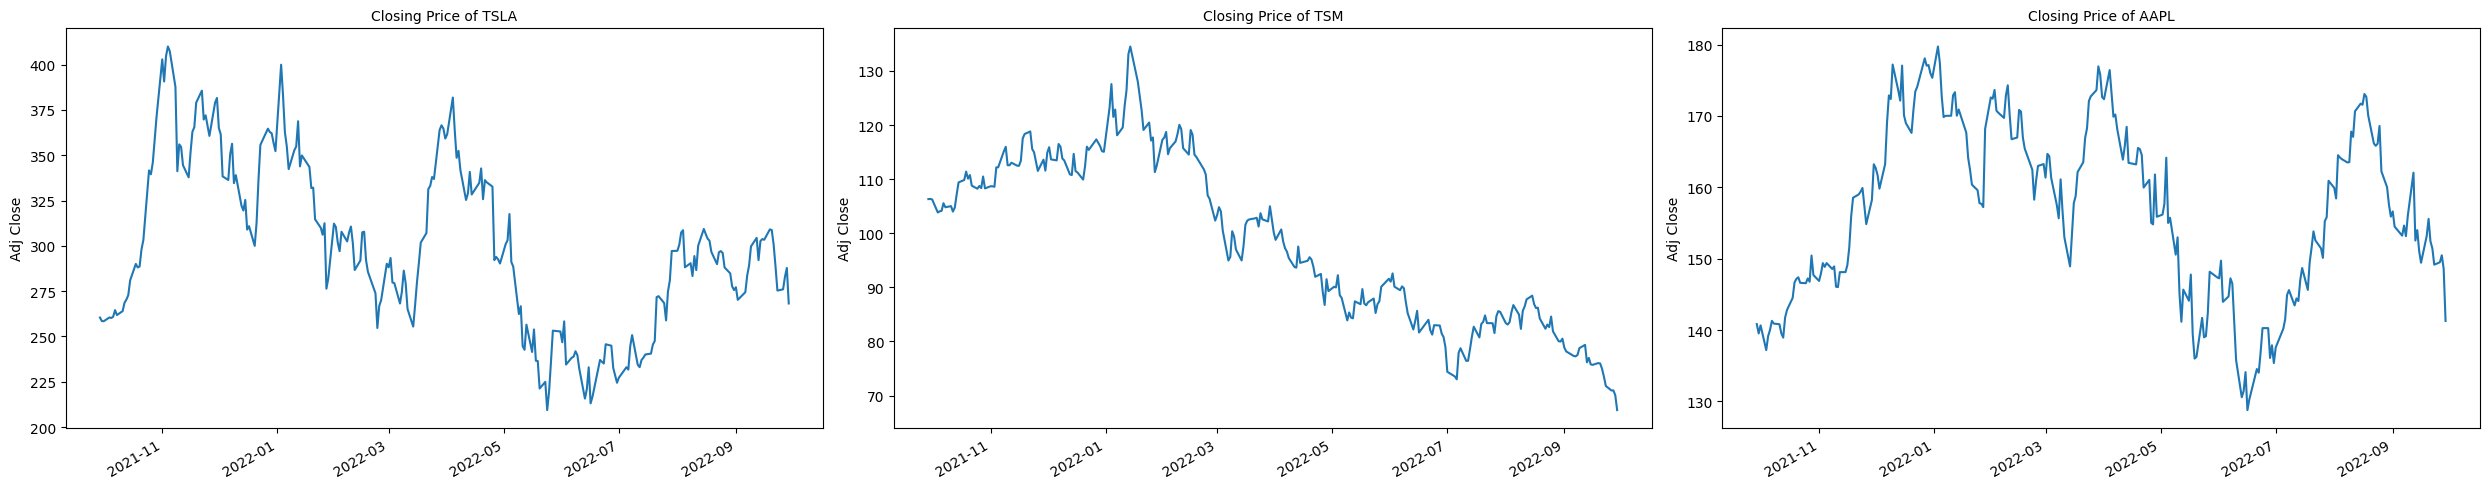

In [ ]:

# Plot out the historical closing price of each stock

plt.figure(figsize=(25,5))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(1, 3, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close', fontsize = 10)
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_name[i - 1]}", fontsize = 10)

plt.tight_layout()

### Prepare the Tweets data

There are 25 in the dataset


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


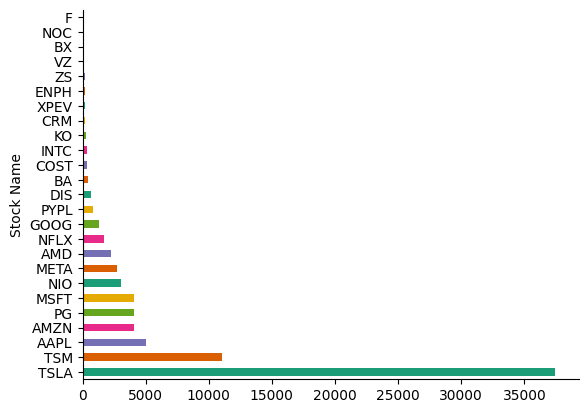

In [ ]:
# Prepare the tweets dataset
tweets_df = pd.read_csv("/content/stock_tweets.csv")
print(f'There are {tweets_df.groupby("Stock Name").ngroups} in the dataset')
tweets_df.groupby('Stock Name').size().sort_values(ascending=False).plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
tweets_df = tweets_df[tweets_df["Stock Name"].isin(company_name)]
tweets_df.describe()
tweets_df.head()

In [ ]:
tweets_df.head(10)

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
5,2022-09-29 22:25:53+00:00,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc."
6,2022-09-29 22:24:22+00:00,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc."
7,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc."
8,2022-09-29 22:23:28+00:00,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc."
9,2022-09-29 22:15:01+00:00,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc."


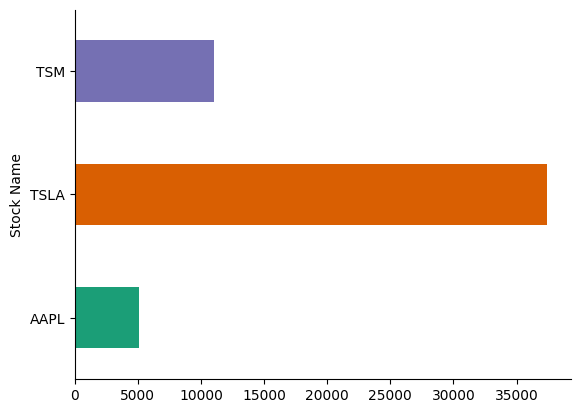

In [ ]:
# @title Stock Name

from matplotlib import pyplot as plt
import seaborn as sns
tweets_df.groupby('Stock Name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Perform sentiment analysis
tweets_df['scores'] = tweets_df['Tweet'].apply(lambda text: analyzer.polarity_scores(text))
tweets_df['compound'] = tweets_df['scores'].apply(lambda score_dict: score_dict['compound'])
tweets_df['sentiment'] = tweets_df['compound'].apply(lambda score: 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral')

# Aggregate sentiment scores by stock/company
sentiment_by_stock = tweets_df.groupby(['Stock Name'])['sentiment'].value_counts().unstack()
sentiment_by_company = tweets_df.groupby('Company Name')['sentiment'].value_counts().unstack()

In [ ]:

# Print results
print("Sentiment by Stock:")
print(sentiment_by_stock)


Sentiment by Stock:
sentiment   negative  neutral  positive
Stock Name                             
AAPL            1055     1742      2259
TSLA            8059    11129     18234
TSM             1970     3533      5531


In [ ]:
tweets_df["Date"] = tweets_df["Date"].str.split(" ")
tweets_df["Date"] = tweets_df["Date"].apply(lambda x:x[0])
tweets_df

,Date,Tweet,Stock Name,Company Name,scores,compound,sentiment
0,2022-09-29,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.","{'neg': 0.127, 'neu': 0.758, 'pos': 0.115, 'co...",0.0772,positive
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.","{'neg': 0.0, 'neu': 0.951, 'pos': 0.049, 'comp...",0.2960,positive
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.","{'neg': 0.273, 'neu': 0.59, 'pos': 0.137, 'com...",-0.7568,negative
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.","{'neg': 0.526, 'neu': 0.474, 'pos': 0.0, 'comp...",-0.8750,negative
...,...,...,...,...,...,...,...
73770,2021-09-30,Hotancold drops 21 kills and a 2.33 rating as ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"{'neg': 0.128, 'neu': 0.623, 'pos': 0.249, 'co...",0.5093,positive
73771,2021-09-30,@TSM_Myth dude SO fun. you killed it pitching ...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"{'neg': 0.324, 'neu': 0.418, 'pos': 0.258, 'co...",-0.2726,negative
73772,2021-09-30,@TSM_Myth You did amazing stop it!!!!!,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"{'neg': 0.197, 'neu': 0.358, 'pos': 0.445, 'co...",0.5815,positive
73773,2021-09-30,@TSM_Myth You did great!!! Don’t be so hard on...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,"{'neg': 0.081, 'neu': 0.432, 'pos': 0.487, 'co...",0.8862,positive


In [ ]:
tweets_by_company = tweets_df.groupby(["Stock Name", "Date"])

tweets_scores = tweets_by_company["compound"].mean()
tweets_scores=pd.DataFrame(tweets_scores['AAPL'])
tweets_scores = tweets_scores.rename(columns={'compound':'sentiment_score'})
tweets_scores = tweets_scores.reset_index()
tweets_scores

,Date,sentiment_score
0,2021-09-30,0.098900
1,2021-10-01,0.291891
2,2021-10-02,0.007525
3,2021-10-03,0.834400
4,2021-10-04,0.047410
...,...,...
360,2022-09-25,0.142021
361,2022-09-26,0.286159
362,2022-09-27,0.256164
363,2022-09-28,-0.042374


### Prepare the final data table

In [ ]:
# Create the technical indicator from the stock data

stock_df['MA7'] = stock_df.iloc[:,4].rolling(window=7).mean()
stock_df['MA20'] = stock_df.iloc[:,4].rolling(window=20).mean()

# Create Exponential moving average
stock_df['EMA'] = stock_df.iloc[:,4].ewm(com=0.5).mean()
stock_df['MACD'] = stock_df.iloc[:,4].ewm(span=26).mean() - stock_df.iloc[:,1].ewm(span=12,adjust=False).mean()

# Create Bollinger Bands
stock_df['20SD'] = stock_df.iloc[:, 4].rolling(20).std()
stock_df['upper_band'] = stock_df['MA20'] + (stock_df['20SD'] * 2)
stock_df['lower_band'] =stock_df['MA20'] - (stock_df['20SD'] * 2)

# Create LogMomentum
stock_df['logmomentum'] = np.log(stock_df.iloc[:,4] - 1)
stock_df


,Date,Open,High,Low,Close,Adj Close,Volume,company_name,MA7,MA20,EMA,MACD,20SD,upper_band,lower_band,logmomentum
0,2021-09-29,259.933319,264.500000,256.893341,260.436676,260.436676,62828700,TSLA,NaN,NaN,260.436676,0.503357,NaN,NaN,NaN,5.558513
1,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,NaN,NaN,258.979179,-0.567221,NaN,NaN,NaN,5.550994
2,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,NaN,NaN,258.582832,-0.852784,NaN,NaN,NaN,5.550657
3,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,NaN,NaN,259.883677,-1.307099,NaN,NaN,NaN,5.558795
4,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,NaN,NaN,260.093191,-1.264870,NaN,NaN,NaN,5.557587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,2022-09-23,151.190002,151.470001,148.559998,150.429993,149.155777,96029900,AAPL,153.048569,156.056999,151.385012,2.400705,3.690484,163.437968,148.676030,5.006828
755,2022-09-26,149.660004,153.770004,149.639999,150.770004,149.492905,93339400,AAPL,152.819999,155.414500,150.975007,2.704848,3.412602,162.239703,148.589297,5.009101
756,2022-09-27,152.740005,154.720001,149.949997,151.759995,150.474518,84442700,AAPL,152.971427,154.933499,151.498332,2.524448,3.198783,161.331065,148.535933,5.015689
757,2022-09-28,147.639999,150.639999,144.839996,149.839996,148.570770,146691400,AAPL,152.308570,154.479999,150.392775,2.985567,3.247914,160.975827,147.984170,5.002872


In [ ]:
final_df_AAPL = stock_df.groupby("company_name").get_group("AAPL").reset_index().merge(tweets_scores, on='Date', how='inner').drop(columns=['index','company_name'])
final_df_TSLA = stock_df.groupby("company_name").get_group("TSLA").reset_index().merge(tweets_scores, on='Date', how='inner').drop(columns=['index','company_name'])
final_df_TSM = stock_df.groupby("company_name").get_group("TSM").reset_index().merge(tweets_scores, on='Date', how='inner').drop(columns=['index','company_name'])
final_df_TSLA

,Date,Open,High,Low,Close,Adj Close,Volume,MA7,MA20,EMA,MACD,20SD,upper_band,lower_band,logmomentum,sentiment_score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,NaN,NaN,258.979179,-0.567221,NaN,NaN,NaN,5.550994,0.098900
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,NaN,NaN,258.582832,-0.852784,NaN,NaN,NaN,5.550657,0.291891
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,NaN,NaN,259.883677,-1.307099,NaN,NaN,NaN,5.558795,0.047410
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,NaN,NaN,260.093191,-1.264870,NaN,NaN,NaN,5.557587,0.139060
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,NaN,NaN,260.642922,-0.674870,NaN,NaN,NaN,5.560361,0.190330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,298.517142,290.471501,281.379917,-3.645233,12.782941,316.037384,264.905618,5.614332,0.018900
248,2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,294.554286,289.867502,277.799979,-1.179826,13.180598,316.228698,263.506306,5.616807,0.286159
249,2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,291.638572,289.773502,281.226661,-0.521519,13.225119,316.223739,263.323265,5.641694,0.256164
250,2022-09-28,283.079987,289.000000,277.570007,287.809998,287.809998,54664800,288.601427,290.279001,285.615552,0.467601,12.929255,316.137511,264.420491,5.658820,-0.042374


In [ ]:
final_df_AAPL = final_df_AAPL.iloc[20:,:].reset_index(drop=True)
final_df_TSLA = final_df_TSLA.iloc[20:,:].reset_index(drop=True)
final_df_TSM = final_df_TSM.iloc[20:,:].reset_index(drop=True)
final_df_AAPL

,Date,Open,High,Low,Close,Adj Close,Volume,MA7,MA20,EMA,MACD,20SD,upper_band,lower_band,logmomentum,sentiment_score
0,2021-10-28,149.820007,153.169998,149.720001,152.570007,150.434677,100077900,149.544288,145.351999,151.359926,-11.635046,3.815009,152.982017,137.721981,5.021048,0.025634
1,2021-10-29,147.220001,149.940002,146.410004,149.800003,147.703430,124953200,149.621432,145.709499,150.319977,-10.702460,3.882887,153.475272,137.943726,5.002603,0.205803
2,2021-11-01,148.990005,149.699997,147.800003,148.960007,146.875168,74588300,149.547147,146.200500,149.413330,-10.154965,3.620448,153.441395,138.959604,4.996942,0.245867
3,2021-11-02,148.660004,151.570007,148.649994,150.020004,147.920364,69122000,149.737148,146.646000,149.817780,-9.481344,3.507520,153.661040,139.630960,5.004081,0.237369
4,2021-11-03,150.389999,151.970001,149.820007,151.490005,149.369827,54511500,150.144291,147.120500,150.932597,-8.987294,3.487778,154.096056,140.144945,5.013897,0.036300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,2022-09-23,151.190002,151.470001,148.559998,150.429993,149.155777,96029900,153.048569,156.056999,151.385012,2.400705,3.690484,163.437968,148.676030,5.006828,0.018900
228,2022-09-26,149.660004,153.770004,149.639999,150.770004,149.492905,93339400,152.819999,155.414500,150.975007,2.704848,3.412602,162.239703,148.589297,5.009101,0.286159
229,2022-09-27,152.740005,154.720001,149.949997,151.759995,150.474518,84442700,152.971427,154.933499,151.498332,2.524448,3.198783,161.331065,148.535933,5.015689,0.256164
230,2022-09-28,147.639999,150.639999,144.839996,149.839996,148.570770,146691400,152.308570,154.479999,150.392775,2.985567,3.247914,160.975827,147.984170,5.002872,-0.042374


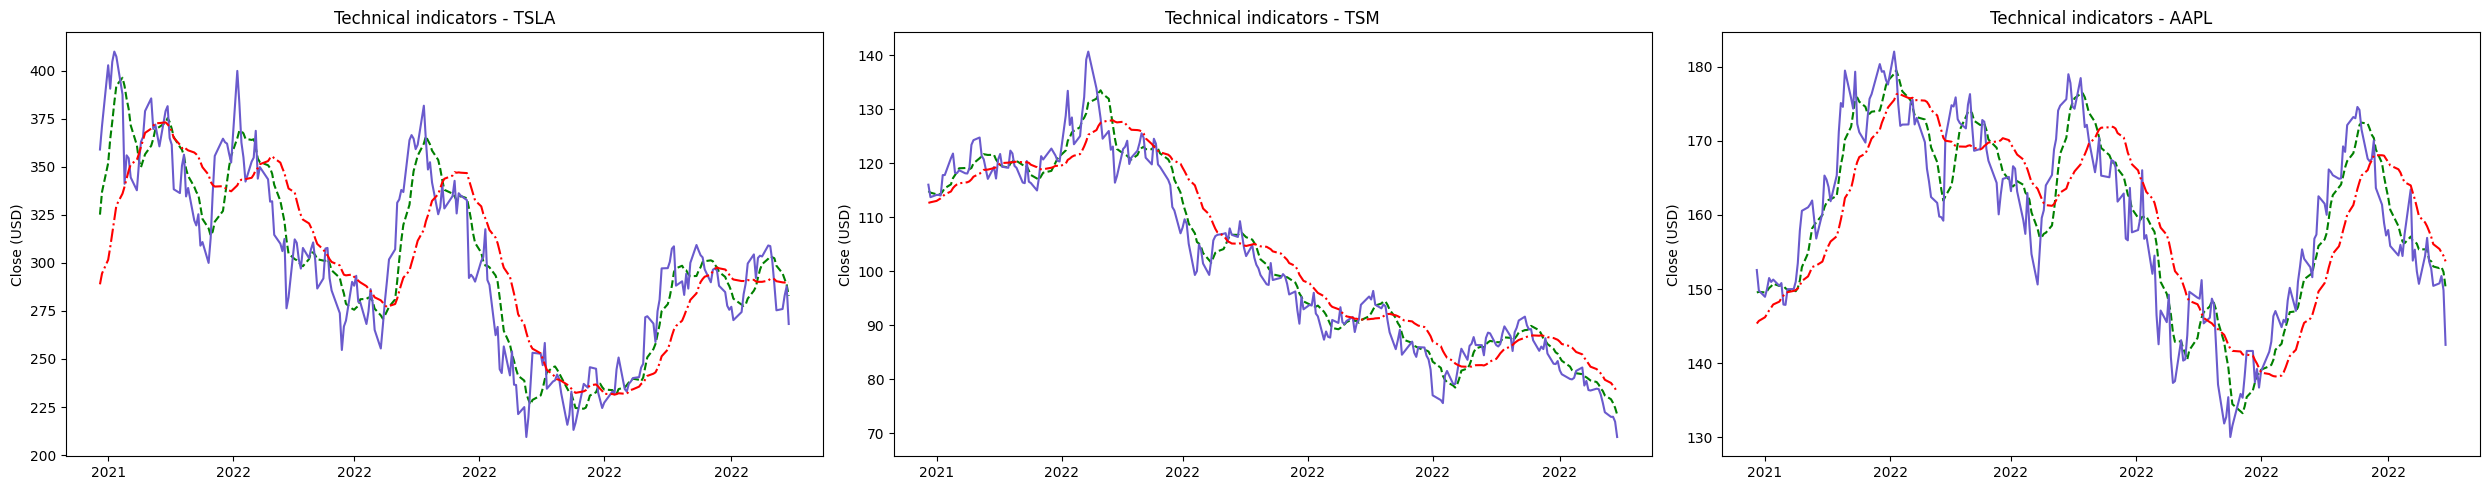

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(25, 5))

# Plot 1


axs[0].plot(pd.to_datetime(final_df_TSLA['Date']), final_df_TSLA['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
axs[0].plot(pd.to_datetime(final_df_TSLA['Date']), final_df_TSLA['Close'], label='Closing Price', color='#6A5ACD')
axs[0].plot(pd.to_datetime(final_df_TSLA['Date']), final_df_TSLA['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
axs[0].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[0].set_ylabel('Close (USD)')
axs[0].set_title('Technical indicators - TSLA')

axs[1].plot(pd.to_datetime(final_df_TSM['Date']), final_df_TSM['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
axs[1].plot(pd.to_datetime(final_df_TSM['Date']), final_df_TSM['Close'], label='Closing Price', color='#6A5ACD')
axs[1].plot(pd.to_datetime(final_df_TSM['Date']), final_df_TSM['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
axs[1].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[1].set_ylabel('Close (USD)')
axs[1].set_title('Technical indicators - TSM')

axs[2].plot(pd.to_datetime(final_df_AAPL['Date']), final_df_AAPL['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
axs[2].plot(pd.to_datetime(final_df_AAPL['Date']), final_df_AAPL['Close'], label='Closing Price', color='#6A5ACD')
axs[2].plot(pd.to_datetime(final_df_AAPL['Date']), final_df_AAPL['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
axs[2].xaxis.set_major_formatter(DateFormatter("%Y"))
axs[2].set_ylabel('Close (USD)')
axs[2].set_title('Technical indicators - AAPL')
plt.tight_layout()
plt.show()

In [ ]:
datetime_series = pd.to_datetime(final_df_AAPL['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)


In [ ]:
final_df_AAPL = final_df_AAPL.set_index(datetime_index)
final_df_AAPL = final_df_AAPL.sort_values(by='Date')
final_df_AAPL = final_df_AAPL.drop(columns='Date')

final_df_TSLA = final_df_TSLA.set_index(datetime_index)
final_df_TSLA = final_df_TSLA.sort_values(by='Date')
final_df_TSLA = final_df_TSLA.drop(columns='Date')

final_df_TSM = final_df_TSM.set_index(datetime_index)
final_df_TSM = final_df_TSM.sort_values(by='Date')
final_df_TSM = final_df_TSM.drop(columns='Date')

## Model Implementation

### Generative Adversarial Network (GAN)


In [ ]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    return (X_scale_dataset, y_scale_dataset, X_scaler, y_scaler)

In [ ]:
def get_train_test(df):
    X_scale_dataset, y_scale_dataset, X_scaler, y_scaler = normalize_data(df, (0,1), "Close")
    X_batched, y_batched, yc = list(), list(), list()
    batch_size = 5
    predict_period = 1
    for i in range(0,len(X_scale_dataset),1):
        x_value = X_scale_dataset[i: i + batch_size][:, :]
        y_value = y_scale_dataset[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_scale_dataset[i: i + batch_size][:, :]
        # print(y_value.shape, yc_value.shape)
        # print(X_scale_dataset.shape, y_scale_dataset.shape)
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)
    X_batched,y_batched,yc= np.array(X_batched), np.array(y_batched), np.array(yc)

    X_train, X_test = split_train_test(X_batched)
    y_train, y_test = split_train_test(y_batched)
    yc_train, yc_test = split_train_test(yc)
    index_train, index_test = predict_index(final_df_AAPL, X_train, 5, 1)

    return X_train, X_test, y_train, y_test, yc_train, yc_test, index_train, index_test, X_scaler, y_scaler


In [ ]:
def build_generator(input_dim, output_dim, feature_size):
    model = Sequential()
    model.add(LSTM(units = 1024, return_sequences = True, input_shape=(input_dim, feature_size),recurrent_dropout = 0.3))
    model.add(LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3))
    model.add(LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3))
    model.add(LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3))
    model.add(LSTM(units = 64, recurrent_dropout = 0.3))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(8))
    model.add(Dense(units=output_dim))
    return model

In [ ]:
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=False))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=False, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, company, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_price = generator(real_x, training=True)
            fake_price_reshape = tf.reshape(fake_price, [fake_price.shape[0], fake_price.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(fake_price_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            real_output = discriminator(d_real_input, training=True)
            fake_output = discriminator(d_fake_input, training=True)

            g_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
            loss = {'d_loss': disc_loss, 'g_loss': g_loss}

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_y)



        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{company}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{company}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test, X_scaler, y_scaler):
    plt.figure(figsize=(25,5))
    plt.subplots_adjust(top=1.25, bottom=1.2)
    rmse_record=[]
    for x in range(len(Real_test_price)):
        test_predict_index = index_test[x]

        rescaled_Real_price = y_scaler[x].inverse_transform(Real_test_price[x])
        rescaled_Predicted_price = y_scaler[x].inverse_transform(Predicted_test_price[x])

        predict_result = pd.DataFrame()
        for i in range(rescaled_Predicted_price.shape[0]):
            y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+1])
            predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

        real_price = pd.DataFrame()
        for i in range(rescaled_Real_price.shape[0]):
            y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+1])
            real_price = pd.concat([real_price, y_train], axis=1, sort=False)

        predict_result['predicted_mean'] = predict_result.mean(axis=1)
        real_price['real_mean'] = real_price.mean(axis=1)

        predicted = predict_result["predicted_mean"]
        real = real_price["real_mean"]
        For_MSE = pd.concat([predicted, real], axis = 1)
        RMSE = np.sqrt(mean_squared_error(predicted, real))
        print('Test RMSE: ', RMSE)
        rmse_record.append(RMSE)
        plt.subplot(1, 3, x+1)
        plt.plot(real_price["real_mean"], color='#00008B')
        plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
        plt.xlabel("Date")
        plt.ylabel("Stock price")
        plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
        plt.title(f"Prediction on test data for {company_name[x]}", fontsize=20)

    plt.tight_layout()
    return rmse_record

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
<ipython-input-27-55dc9f301df2>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator, f'./models_gan/{company}/generator_V_%d.h5' % epoch)
<ipython-input-27-55dc9f301df2>:44: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator, f'./models_gan/{company}/discriminator_V_%d.h5' % epoch)


epoch 50 discriminator_loss 1.3846947 generator_loss 0.66238624


epoch 100 discriminator_loss 1.3866892 generator_loss 0.69152266


epoch 150 discriminator_loss 1.4021964 generator_loss 0.7240808


epoch 200 discriminator_loss 1.3960268 generator_loss 0.69251925


epoch 250 discriminator_loss 1.3869886 generator_loss 0.6935187


epoch 300 discriminator_loss 1.3853512 generator_loss 0.6937539


epoch 350 discriminator_loss 1.3842402 generator_loss 0.69372153


epoch 400 discriminator_loss 1.3861177 generator_loss 0.69173646


epoch 450 discriminator_loss 1.389334 generator_loss 0.69201326


epoch 500 discriminator_loss 1.3874359 generator_loss 0.6928917


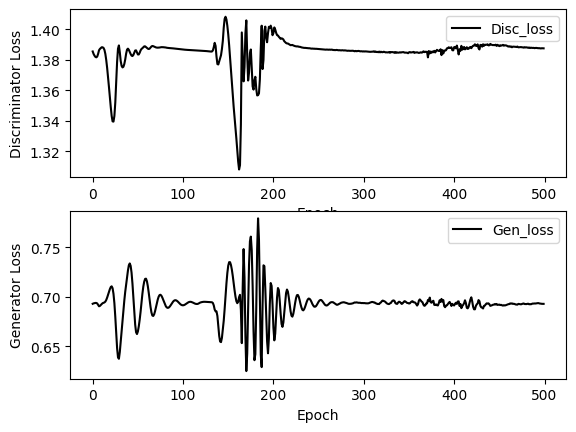

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
<ipython-input-27-55dc9f301df2>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator, f'./models_gan/{company}/generator_V_%d.h5' % epoch)
<ipython-input-27-55dc9f301df2>:44: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator, f'./models_gan/{company}/discriminator_V_%d.h5' % epoch)


epoch 50 discriminator_loss 1.4293625 generator_loss 0.6108286


epoch 100 discriminator_loss 1.4440024 generator_loss 0.6574588


epoch 150 discriminator_loss 1.3788668 generator_loss 0.7042679


epoch 200 discriminator_loss 1.3857956 generator_loss 0.69530195


epoch 250 discriminator_loss 1.3864751 generator_loss 0.6942943


epoch 300 discriminator_loss 1.3866553 generator_loss 0.69435835


epoch 350 discriminator_loss 1.3863888 generator_loss 0.6936107


epoch 400 discriminator_loss 1.3862765 generator_loss 0.6933299


epoch 450 discriminator_loss 1.3861451 generator_loss 0.69320613


epoch 500 discriminator_loss 1.3864615 generator_loss 0.6927292


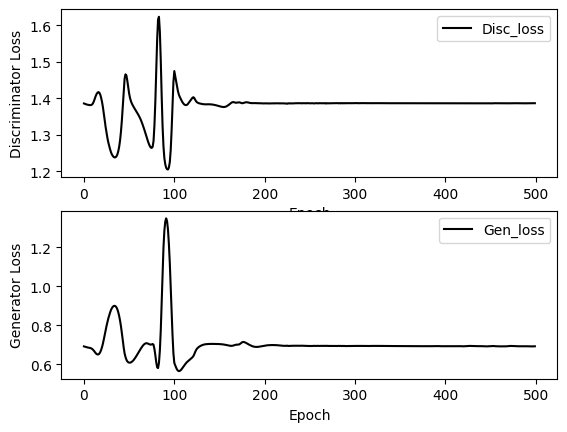

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
<ipython-input-27-55dc9f301df2>:43: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator, f'./models_gan/{company}/generator_V_%d.h5' % epoch)
<ipython-input-27-55dc9f301df2>:44: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(discriminator, f'./models_gan/{company}/discriminator_V_%d.h5' % epoch)


epoch 50 discriminator_loss 1.3775301 generator_loss 0.6503293


epoch 100 discriminator_loss 1.3852738 generator_loss 0.66954035


epoch 150 discriminator_loss 1.3832892 generator_loss 0.68849736


epoch 200 discriminator_loss 1.3724585 generator_loss 0.71244776


epoch 250 discriminator_loss 1.3729587 generator_loss 0.7275109


epoch 300 discriminator_loss 1.3699366 generator_loss 0.70339805


epoch 350 discriminator_loss 1.3721043 generator_loss 0.6631327


epoch 400 discriminator_loss 1.387397 generator_loss 0.703727


epoch 450 discriminator_loss 1.3861411 generator_loss 0.7005135


epoch 500 discriminator_loss 1.3837824 generator_loss 0.68471795


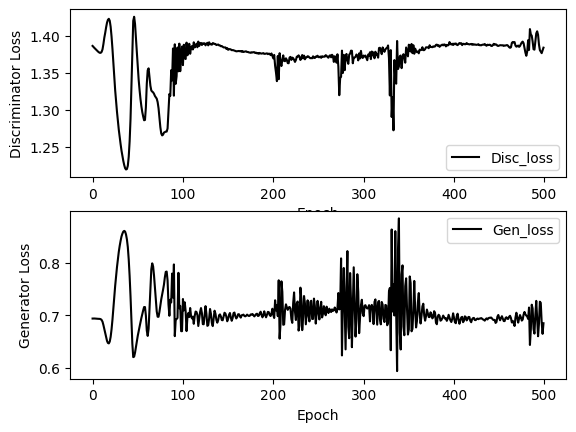

In [ ]:
learning_rate = 5e-4
epochs = 500

# Train and test model for AAPL
g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
AAPL_X_train, AAPL_X_test, AAPL_y_train, AAPL_y_test, AAPL_yc_train, AAPL_yc_test, AAPL_index_train, AAPL_index_test, AAPL_X_scaler, AAPL_y_scaler = get_train_test(final_df_AAPL)
generator = build_generator(AAPL_X_train.shape[1], AAPL_y_train.shape[1], AAPL_X_train.shape[2])
discriminator = build_discriminator(AAPL_X_train.shape[1])
AAPL_predicted_price, AAPL_real_price, AAPL_RMSPE = train(AAPL_X_train, AAPL_y_train, AAPL_yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer, "AAPL")
test_generator = tf.keras.models.load_model(f'./models_gan/AAPL/generator_V_{epochs-1}.h5')
AAPL_predicted_test_data = test_generator(AAPL_X_test, training = False)

# Train and test model for TSLA
g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
TSLA_X_train, TSLA_X_test, TSLA_y_train, TSLA_y_test, TSLA_yc_train, TSLA_yc_test, TSLA_index_train, TSLA_index_test, TSLA_X_scaler, TSLA_y_scaler = get_train_test(final_df_TSLA)
generator = build_generator(TSLA_X_train.shape[1], TSLA_y_train.shape[1], TSLA_X_train.shape[2])
discriminator = build_discriminator(TSLA_X_train.shape[1])
TSLA_predicted_price, TSLA_real_price, TSLA_RMSPE = train(TSLA_X_train, TSLA_y_train, TSLA_yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer, "TSLA")
test_generator = tf.keras.models.load_model(f'./models_gan/TSLA/generator_V_{epochs-1}.h5')
TSLA_predicted_test_data = test_generator(TSLA_X_test, training = False)

# Train and test model for TSM
g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
TSM_X_train, TSM_X_test, TSM_y_train, TSM_y_test, TSM_yc_train, TSM_yc_test, TSM_index_train, TSM_index_test, TSM_X_scaler, TSM_y_scaler = get_train_test(final_df_TSM)
generator = build_generator(TSM_X_train.shape[1], TSM_y_train.shape[1], TSM_X_train.shape[2])
discriminator = build_discriminator(TSM_X_train.shape[1])
TSM_predicted_price, TSM_real_price, TSM_RMSPE = train(TSM_X_train, TSM_y_train, TSM_yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer, "TSM")
test_generator = tf.keras.models.load_model(f'./models_gan/TSM/generator_V_{epochs-1}.h5')
TSM_predicted_test_data = test_generator(TSM_X_test, training = False)

Test RMSE:  12.869064580692887
accuracy:  0.0386076379228234
Test RMSE:  6.487931226175152
accuracy:  -2.4019531709539885
Test RMSE:  4.703190659159229
accuracy:  -0.35680953602201027
[12.869064580692887, 6.487931226175152, 4.703190659159229]


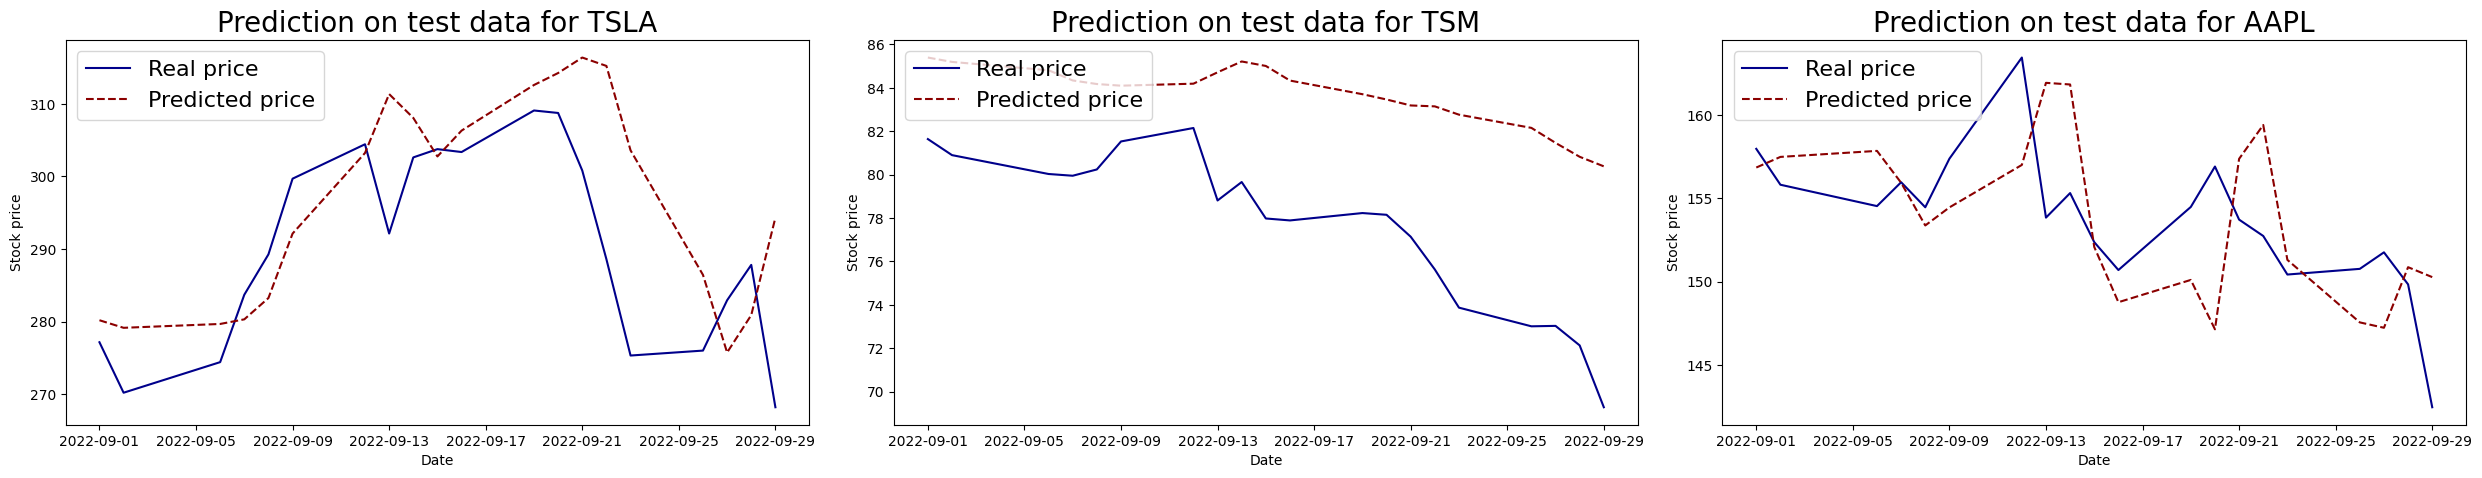

In [ ]:
Real_test_price = [TSLA_y_test, TSM_y_test, AAPL_y_test]
Predicted_test_price = [TSLA_predicted_test_data, TSM_predicted_test_data, AAPL_predicted_test_data]
index_test = [TSLA_index_test, TSM_index_test, AAPL_index_test]
X_scaler = [TSLA_X_scaler, TSM_X_scaler, AAPL_X_scaler]
y_scaler = [TSLA_y_scaler, TSM_y_scaler, AAPL_y_scaler]
rmse_record=plot_test_data(Real_test_price, Predicted_test_price, index_test, X_scaler, y_scaler)

Text(0, 0.5, 'RMSE loss')

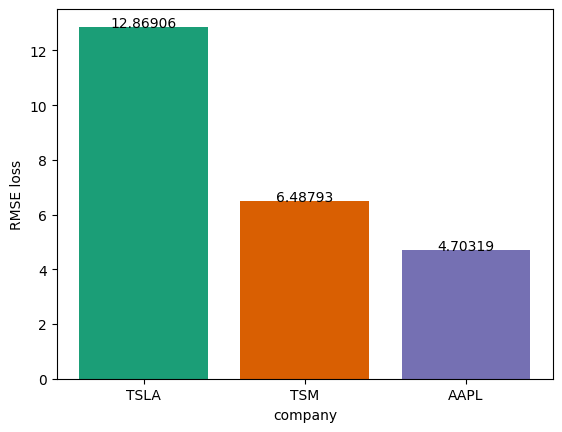

In [ ]:
plt.bar(company_name, rmse_record, color=sns.palettes.mpl_palette('Dark2'))
for i in range(len(company_name)):
  plt.text(i, round(rmse_record[i],5), round(rmse_record[i],5), ha='center')
plt.xlabel("company")
plt.ylabel("RMSE loss")


### Long Short Term Memory (LSTM)

In [ ]:
stock_groups = stock_df.groupby(['company_name'])
stock_close = stock_groups.get_group('TSLA').filter(['Close'])
# stock_close = pd.concat([stock_close, stock_groups.get_group('AAPL').filter(['Close']).reset_index()], axis=1).drop(columns=['index'])
stock_close = pd.concat([stock_close, stock_groups.get_group('TSM').filter(['Close']).reset_index()], axis=1).drop(columns=['index'])
stock_close = pd.concat([stock_close, stock_groups.get_group('AAPL').filter(['Close']).reset_index()], axis=1).drop(columns=['index'])

stock_close.columns = company_name
stock_close

,TSLA,TSM,AAPL
0,260.436676,111.620003,142.830002
1,258.493347,111.650002,141.500000
2,258.406677,111.559998,142.649994
3,260.510010,109.019997,139.139999
4,260.196655,109.260002,141.110001
...,...,...,...
248,275.329987,73.870003,150.429993
249,276.010010,73.010002,150.770004
250,282.940002,73.029999,151.759995
251,287.809998,72.129997,149.839996


In [ ]:
predicting_company = 'TSM'

scaled_data = {}
scalers = {}
for name in company_name:
  scaled_data[name] = stock_close[name].values
  scalers[name] = MinMaxScaler(feature_range=(0,1))
  scaled_data[name] = scalers[name].fit_transform([[item] for item in scaled_data[name]])

In [ ]:
train_data_len=int(np.ceil(len(scaled_data[predicting_company])*.95))

In [ ]:
x_train = {name: [] for name in company_name}
y_train = {name: [] for name in company_name}
days=60
for name in company_name:
  train_data = scaled_data[name][0:int(train_data_len), :]
  for i in range(days, len(train_data)):
      x_train[name].append(train_data[i-days:i,0])
      y_train[name].append(train_data[i,0])

# Convert the x_train and y_train to numpy arrays
  x_train[name], y_train[name] = np.array(x_train[name]), np.array(y_train[name])

# Reshape the data
  x_train[name] = np.reshape(x_train[name], (x_train[name].shape[0], x_train[name].shape[1], 1))

In [ ]:
def build_LSTM_model():
    model = Sequential()
    #model.add(LSTM(128, return_sequences=True, input_shape= (x_train[predicting_company].shape[1], 1)))
    #model.add(LSTM(64, return_sequences=False))
    #model.add(Dense(25))
    #model.add(Dense(1))
    model.add(LSTM(256, return_sequences=True, input_shape= (x_train[predicting_company].shape[1], 1)))
    # model.add(Dropout(0.2))

    model.add(LSTM(128, return_sequences=True))
    # model.add(Dropout(0.1))

    model.add(LSTM(64, return_sequences=True))
    # model.add(Dropout(0.2))

    model.add(LSTM(32))
    # model.add(Dropout(0.1))

    model.add(Dense(32))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model



In [ ]:
test_data_len=len(scaled_data[predicting_company][train_data_len - days: , :])
x_test = {name: [] for name in company_name}
y_test = {name: [] for name in company_name}
for name in company_name:
  test_data = scaled_data[name][train_data_len - days: , :]
  for i in range(days,test_data_len):
    x_test[name].append(test_data[i-days:i, 0])
  y_test[name] = pd.DataFrame(stock_close[name]).values[train_data_len:, :]
  x_test[name],y_test[name]=np.array(x_test[name]),np.array(y_test[name])
  x_test[name]=np.reshape(x_test[name],(x_test[name].shape[0],x_test[name].shape[1],1))

Epoch 1/25
181/181 [==============================] - 8s 11ms/step - loss: 0.0371
Epoch 2/25
181/181 [==============================] - 3s 15ms/step - loss: 0.0164
Epoch 3/25
181/181 [==============================] - 2s 13ms/step - loss: 0.0132
Epoch 4/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0153
Epoch 5/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0125
Epoch 6/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0107
Epoch 7/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0090
Epoch 8/25
181/181 [==============================] - 3s 14ms/step - loss: 0.0072
Epoch 9/25
181/181 [==============================] - 2s 13ms/step - loss: 0.0060
Epoch 10/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0056
Epoch 11/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0051
Epoch 12/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0067
Epoch 13/25
1

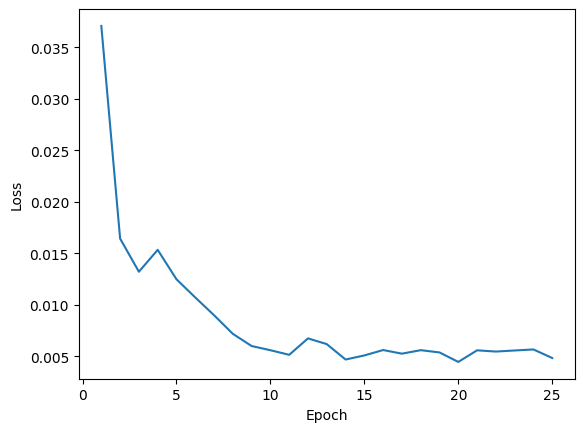

1/1 [==============================] - 2s 2s/step
accuracy 0.5417074726258396
Epoch 1/25
181/181 [==============================] - 7s 11ms/step - loss: 0.0175
Epoch 2/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0108
Epoch 3/25
181/181 [==============================] - 3s 15ms/step - loss: 0.0078
Epoch 4/25
181/181 [==============================] - 2s 13ms/step - loss: 0.0072
Epoch 5/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0063
Epoch 6/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0045
Epoch 7/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0062
Epoch 8/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0051
Epoch 9/25
181/181 [==============================] - 3s 16ms/step - loss: 0.0041
Epoch 10/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0036
Epoch 11/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0048
Epoch 12/25
181/18

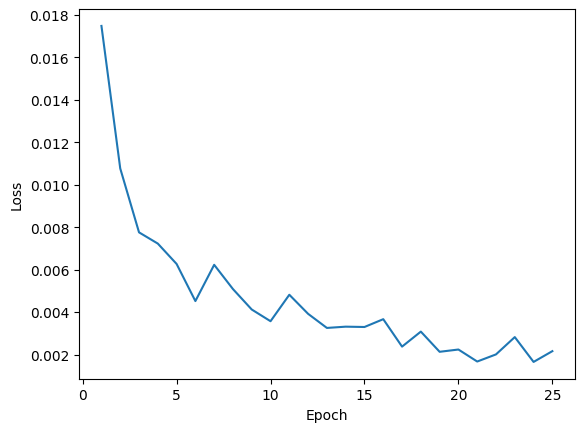

1/1 [==============================] - 1s 1s/step
accuracy 0.6936817126697998
Epoch 1/25
181/181 [==============================] - 8s 12ms/step - loss: 0.0427
Epoch 2/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0257
Epoch 3/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0226
Epoch 4/25
181/181 [==============================] - 2s 13ms/step - loss: 0.0177
Epoch 5/25
181/181 [==============================] - 3s 14ms/step - loss: 0.0113
Epoch 6/25
181/181 [==============================] - 2s 12ms/step - loss: 0.0089
Epoch 7/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0106
Epoch 8/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0084
Epoch 9/25
181/181 [==============================] - 2s 11ms/step - loss: 0.0087
Epoch 10/25
181/181 [==============================] - 2s 14ms/step - loss: 0.0068
Epoch 11/25
181/181 [==============================] - 3s 14ms/step - loss: 0.0071
Epoch 12/25
181/18

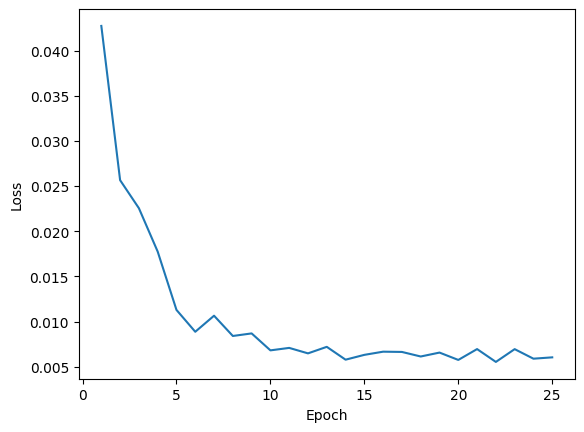

1/1 [==============================] - 1s 1s/step
accuracy -0.3414662013061849


In [ ]:
predictions = {}
rmse = {}
epochs = 25
for i, company in enumerate(company_name):
    # Build the model
    model = build_LSTM_model();

    # Train the model
    history = model.fit(x_train[company], y_train[company], batch_size=1, epochs=epochs)
    xs = [x+1 for x in range(epochs)]
    plt.plot(xs, history.history['loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    # x, y = zip(*(history.history).items())
    # plt.plot(x, y)
    # plt.show()

    prediction = model.predict(x_test[company])
    prediction = scalers[company].inverse_transform(prediction)
    predictions[company] = prediction
    # Get the root mean squared error (RMSE)
    rmse[company] = np.sqrt(np.mean(((prediction - y_test[company]) ** 2)))

Text(0, 0.5, 'RMSE loss')

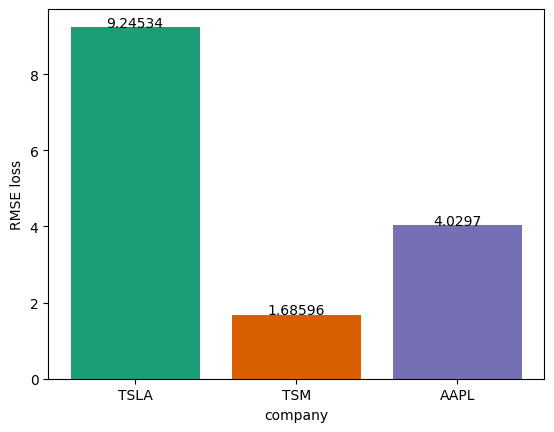

In [ ]:
x, y = zip(*rmse.items())
plt.bar(x, y, color=sns.palettes.mpl_palette('Dark2'))
for i in range(len(x)):
  plt.text(i, round(y[i],5), round(y[i],5), ha='center')
plt.xlabel("company")
plt.ylabel("RMSE loss")


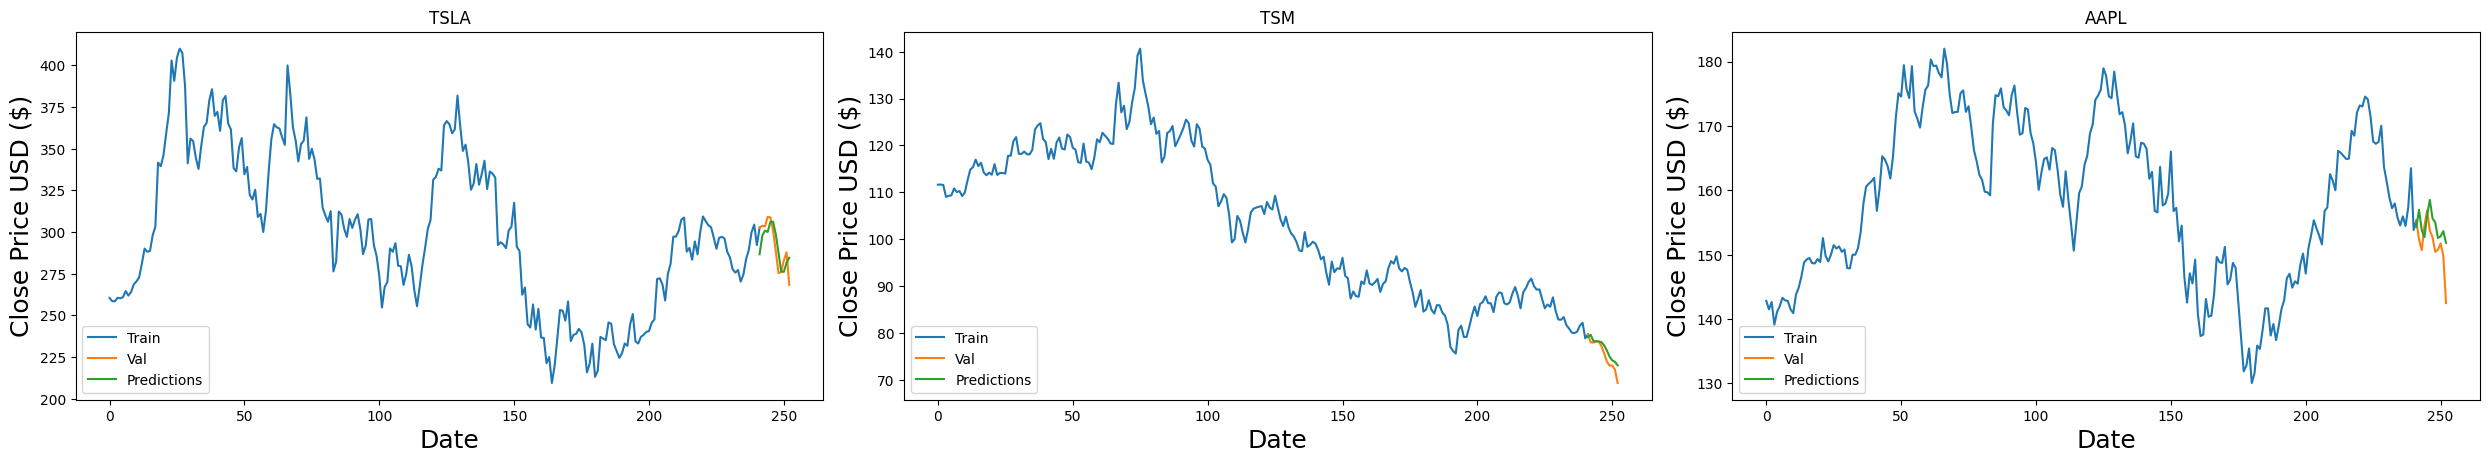

In [ ]:
plt.figure(figsize=(25,5))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_name, 1):
    plt.subplot(1, 3, i)
    valid=pd.DataFrame()
    train = stock_close[company][:train_data_len+1]
    valid['Close']=pd.DataFrame(stock_close[company][train_data_len:])
    valid['Predictions'] = predictions[company]
    # Visualize the data
    plt.title(company)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train)
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower left')

plt.tight_layout()